In [1]:
import casadi
from casadi import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
from scipy.signal import cont2discrete as c2d
from math import pi

In [32]:
N = 5
T = 0.1

In [33]:
# Given parameters
M = 0.5
m = 0.2
l = 0.3
I = 0.006
b = 0.1
g = 9.81

# Continuous-time state-space matrices
A = np.array([
    [0, 1, 0, 0],
    [0, -(I + m * l**2) * b / (I * (M + m) + M * m * l**2), (m**2 * g * l**2) / (I * (M + m) + M * m * l**2), 0],
    [0, 0, 0, 1],
    [0, -(m * l * b) / (I * (M + m) + M * m * l**2), (m * g * l * (M + m)) / (I * (M + m) + M * m * l**2), 0]
])

B = np.array([
    [0],
    [(I + m * l**2) / (I * (M + m) + M * m * l**2)],
    [0],
    [m * l / (I * (M + m) + M * m * l**2)]
])

C = np.eye(4)
D = np.zeros((4, 1))

# Discretization with sampling time T = 0.1s
# T = 0.1
system = (A, B, C, D)
sysd = c2d(system, T)
Ad, Bd, _, _, _ = sysd

# add row of zeros
Ad = np.concatenate((Ad, np.zeros((1,4))))
# then a column of zeros
Ad = np.concatenate((Ad, np.zeros((5,1))), axis=1)
# Extend B from a 4x1 column vector, to a 5x1 column vector
# Add an new row at the bottom, with the element = 1:
Bd = np.concatenate((Bd, np.ones((1,1))))

In [34]:
# print(Ad)
# print(Bd)

A = DM(Ad)
B = DM(Bd)

# print(A.shape)
# print(B.shape)

print(A[0,:])
print(B[:,0])

[[1, 0.0990913, 0.0136466, 0.000450875, 0]]
[0.00908689, 0.182215, 0.0231849, 0.474325, 1]


In [35]:
Q = DM(np.eye(5))
R = DM(np.eye(1))

Q[0,0] = 100
Q[1,1] = 0.005
Q[2,2] = 250
Q[3,3] = 0.005
Q[4,4] = 0


R[0,0] = 0

In [36]:
opti = Opti()

x = opti.variable(5,N)
u = opti.variable(1,N-1)

x_bar = opti.parameter(5,1)

In [37]:
# Objective function (summation of quadratic terms)
J = 0
for k in range(N-1):
    # J += (x[:, k].T @ Q @ x[:, k] + u[:, k].T @ R @ u[:, k])  # Track error and control effort
    state = x[:, k].T @ Q @ x[:, k]
    state = mtimes( [x[:, k].T , Q , x[:, k]] )
    # print(state.shape)
    # input = u[:, k].T @ R @ u[:, k]
    input = mtimes([ u[:, k].T , R , u[:, k] ])
    # print(input.shape)
    J += state + input

J += x[:, N-1].T @ Q @ x[:, N-1]

# print(J)

opti.minimize(J)

In [38]:
# State update constraint
for k in range(N-1):

    x_next = A @ x[:, k]+ B @ u[:, k]
    opti.subject_to(x[:,k+1] == x_next)  # Enforce state update using system dynamics

    # print(x_next.shape)

In [39]:
theta_max = opti.parameter()
opti.set_value(theta_max, 15*pi/180)

input_max = opti.parameter()
opti.set_value(input_max, 2)

slew_max = opti.parameter()
opti.set_value(slew_max, 0.1)

# State constraints
for k in range(N):
    opti.subject_to( x[2,k] <= theta_max)
    opti.subject_to( -theta_max <= x[2,k]  )

# input constraints:
for k in range(N-1):
    opti.subject_to( u[0,k] <= input_max)
    opti.subject_to(  -input_max <= u[0,k] )

# Slew rate constraints
for k in range(N-1):
    opti.subject_to(  u[0,k] - x[4,k] <= slew_max )
    opti.subject_to( -slew_max <= u[0,k] - x[4,k]  )

# Initial Value
opti.subject_to(x[:,0] == x_bar)

In [40]:
# Set initial state value
x0 = DM([-0.4, 14*pi/180, 0, 0, 0]) 
print(x0.shape)
opti.set_value(x_bar, x0 )

(5, 1)


In [41]:
opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opti.solver('ipopt', opts)
sol = opti.solve()

In [42]:
# print(sol.value(x))
print(sol.value(u))

[ 0.1         0.19102434  0.09102434 -0.00897563]


# Simulate

In [43]:
x0 = DM([-0.4, 14*pi/180, 0, 0, 0])
opti.set_value(x_bar, x0 )
opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opti.solver('ipopt', opts)
sol = opti.solve()
print(sol.value(u))

[ 0.1         0.19102434  0.09102434 -0.00897563]


In [47]:
steps = 150
opts = {'ipopt.print_level': 0, 'print_time': 0, 'ipopt.sb': 'yes'}
opti.solver('ipopt', opts)

X = np.zeros( (5,steps) )
U = np.zeros( (1,steps) )

# x0 = [-0.2, 7*pi/180, 0, 0, 0]
x0 = [-0.4, 14*pi/180, 0, 0, 0]
opti.set_value(x_bar, x0 )

for i in range(steps):
    sol = opti.solve()
    curr_u = sol.value(u)[0]
    X[:,i] = np.array(x0).flatten()
    U[:,i] = curr_u
    x0 = mtimes(A , x0) + mtimes(B, curr_u)
    opti.set_value(x_bar, x0 )

In [48]:
state1 = X[0,:]
state2 = X[1,:]
state3 = X[2,:] * (180/pi)
state4 = X[3,:] * (180/pi)
state5 = U[0,:] - X[4,:] 

ctl_sig = U[0,:]

t = np.linspace(0,steps-1,steps)

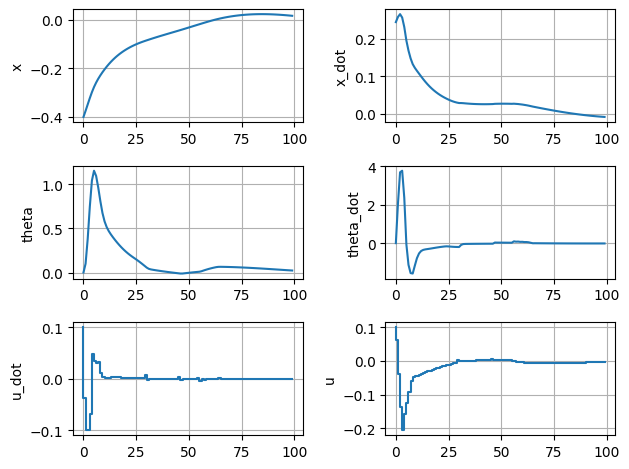

In [ ]:
end = steps

plt.subplot(3,2,1)
plt.plot(state1[:end])
plt.ylabel('x')
plt.grid()

plt.subplot(3,2,2)
plt.ylabel('x_dot')
plt.plot(state2[:end])
plt.grid()

plt.subplot(3,2,3)
plt.ylabel('theta')
plt.plot(state3[:end])
plt.grid()

plt.subplot(3,2,4)
plt.ylabel('theta_dot')
plt.plot(state4[:end])
plt.grid()

plt.subplot(3,2,5)
plt.ylabel('u_dot')
plt.step(t[:end],state5[:end])
plt.grid()

plt.subplot(3,2,6)
plt.ylabel('u')
plt.step(t[:end],ctl_sig[:end])
plt.grid()


plt.tight_layout()
plt.show()